<a href="https://colab.research.google.com/github/dimahdera/VDP_MLP/blob/master/VDP_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
#tf.get_logger().setLevel('ERROR')

In [ ]:
print(tf.__version__)


2.2.0


In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], -1) / 255
x_test = x_test.reshape(x_test.shape[0], -1) / 255

batch_size = 10 # MUST HAVE ALL BATCHES of EQUAL SIZE (The last one may mess some )

tr_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
import numpy as np

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], -1) / 255
x_test = x_test.reshape(x_test.shape[0], -1) / 255

batch_size = 10 # MUST HAVE ALL BATCHES of EQUAL SIZE (The last one may mess some )

one_hot_y_train = tf.one_hot(y_train.astype(np.float32), depth=10)
one_hot_y_test = tf.one_hot(y_test.astype(np.float32), depth=10)


tr_dataset = tf.data.Dataset.from_tensor_slices((x_train, one_hot_y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_test, one_hot_y_test)).batch(batch_size)

In [ ]:
x_train.shape

(60000, 784)

In [ ]:
tr_dataset

<BatchDataset shapes: ((None, 784), (None, 10)), types: (tf.float64, tf.float32)>

In [ ]:
def x_Sigma_w_x_T(x, W_Sigma):
  batch_sz = x.shape[0]
  xx_t = tf.reduce_sum(tf.multiply(x, x),axis=1, keepdims=True)               # xxT is being calcualted
  xx_t_e = tf.expand_dims(xx_t,axis=2)                                      # Expand dimention of xxt
  return tf.multiply(xx_t_e, W_Sigma)

def w_t_Sigma_i_w (w_mu, in_Sigma):
  Sigma_1_1 = tf.matmul(tf.transpose(w_mu), in_Sigma)
  Sigma_1_2 = tf.matmul(Sigma_1_1, w_mu)
  return Sigma_1_2

def tr_Sigma_w_Sigma_in (in_Sigma, W_Sigma):
  Sigma_3_1 = tf.linalg.trace(in_Sigma)
  Sigma_3_2 = tf.expand_dims(Sigma_3_1, axis=1)
  Sigma_3_3 = tf.expand_dims(Sigma_3_2, axis=1)
  return tf.multiply(Sigma_3_3, W_Sigma) 

def activation_Sigma (gradi, Sigma_in):
  grad1 = tf.expand_dims(gradi,axis=2)
  grad2 = tf.expand_dims(gradi,axis=1)
  return tf.multiply(Sigma_in, tf.matmul(grad1, grad2))

In [ ]:
# Linear Class - First Layer (Constant * RV)
class LinearFirst(keras.layers.Layer):
    """y = w.x + b"""

    def __init__(self, units):
        super(LinearFirst, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w_mu = self.add_weight(name='w_mu',
            shape=(input_shape[-1], self.units),
            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.05, seed=None),
            trainable=True
        )
        self.w_sigma = self.add_weight(name='w_sigma',
            shape=(self.units,),
            initializer=tf.random_uniform_initializer(minval= -12., maxval=-2.2, seed=None),
            trainable=True
        )
        self.b_mu = self.add_weight(name='b_mu',
            shape=(self.units,), initializer=tf.random_normal_initializer( mean=0.0, stddev=0.00005, seed=None),
            trainable=True
        )
        self.b_sigma = self.add_weight(name='b_sigma',
            shape=(self.units,), initializer=tf.random_uniform_initializer(minval= -12., maxval=-10., seed=None),
            trainable=True
        )
    def call(self, inputs):
        # Mean
        #print(self.w_mu.shape)
        mu_out = tf.matmul(inputs, self.w_mu) + self.b_mu                         # Mean of the output
        # Varinace
        W_Sigma = tf.linalg.diag(tf.math.log(1. + tf.math.exp(self.w_sigma)))                                    # Construct W_Sigma from w_sigmas
        #W_Sigma = tf.linalg.diag(self.w_sigma)                                    # Construct W_Sigma from w_sigmas
        Sigma_out = x_Sigma_w_x_T(inputs, W_Sigma) + tf.math.log(1. + tf.math.exp(self.b_sigma)) #tf.linalg.diag(self.b_sigma)

        Term1 = tf.reduce_mean(tf.math.log(1.0 + Sigma_out))
        Term2 = tf.reduce_mean(tf.square(mu_out))
        Term3 = tf.reduce_mean(Sigma_out)
      
        kl_loss = -0.5 * (Term1 - Term2 - Term3)
        self.add_loss(kl_loss)

        return mu_out, Sigma_out


In [ ]:
# Linear Class - Second Layer (RV * RV)
class LinearNotFirst(keras.layers.Layer):
    """y = w.x + b"""

    def __init__(self, units):
        super(LinearNotFirst, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w_mu = self.add_weight(name='w_mu',
            shape=(input_shape[-1], self.units),
            initializer=tf.random_normal_initializer( mean=0.0, stddev=0.05, seed=None),
            trainable=True,
        )
        self.w_sigma = self.add_weight(name='w_sigma',
            shape=(self.units,),
            initializer=tf.random_uniform_initializer(minval= -12., maxval=-2.2, seed=None),
            trainable=True,
        )
        self.b_mu = self.add_weight(name='b_mu',
            shape=(self.units,), initializer=tf.random_normal_initializer( mean=0.0, stddev=0.00005, seed=None),
            trainable=True,
        )
        self.b_sigma = self.add_weight(name='b_sigma',
            shape=(self.units,), initializer=tf.random_uniform_initializer(minval= -12., maxval=-10., seed=None),
            trainable=True,
        )

    def call(self, mu_in, Sigma_in):
        #batch_sz = mu_in.shape[0]
        mu_out = tf.matmul(mu_in, self.w_mu) + self.b_mu
        W_Sigma = tf.linalg.diag(tf.math.log(1. + tf.math.exp(self.w_sigma)))  
        #W_Sigma = tf.linalg.diag(self.w_sigma)                                    # Construct W_Sigma from w_sigmas
        # Simga_out has three terms
        Sigma_1 = w_t_Sigma_i_w (self.w_mu, Sigma_in)
        Sigma_2 = x_Sigma_w_x_T(mu_in, W_Sigma)                                   #tf.keras.backend.print_tensor(inputs2[0,:,:])
        Sigma_3 = tr_Sigma_w_Sigma_in (Sigma_in, W_Sigma)
        Sigma_out = Sigma_1 + Sigma_2 + Sigma_3 +tf.linalg.diag(tf.math.log(1. + tf.math.exp(self.b_sigma)))  #+ tf.linalg.diag(self.b_sigma)
        
        Term1 = tf.reduce_mean(tf.math.log(1.0 + Sigma_out))
        Term2 = tf.reduce_mean(tf.square(mu_out))
        Term3 = tf.reduce_mean(Sigma_out)
        kl_loss = -0.5 * (Term1 - Term2 - Term3)
        self.add_loss(kl_loss)
        return mu_out, Sigma_out


In [ ]:
class myReLU(keras.layers.Layer):
    """ReLU"""

    def __init__(self):
        super(myReLU, self).__init__()
    def call(self, mu_in, Sigma_in):
        mu_out = tf.nn.relu(mu_in)
        with tf.GradientTape() as g:
          g.watch(mu_in)
          out = tf.nn.relu(mu_in)
        gradi = g.gradient(out, mu_in) 

        Sigma_out = activation_Sigma (gradi, Sigma_in)
        
        return mu_out, Sigma_out


In [ ]:
class mysoftmax(keras.layers.Layer):
    """Mysoftmax"""

    def __init__(self):
        super(mysoftmax, self).__init__()
    def call(self, mu_in, Sigma_in):
        mu_out = tf.nn.softmax(mu_in)
        pp1 = tf.expand_dims(mu_out, axis=2)
        pp2 = tf.expand_dims(mu_out, axis=1)
        ppT = tf.matmul(pp1, pp2)
        p_diag = tf.linalg.diag(mu_out)
        grad = p_diag - ppT
        Sigma_out = tf.matmul(grad, tf.matmul(Sigma_in, tf.transpose(grad, perm=[0, 2, 1])))
        return mu_out, Sigma_out


In [ ]:
# Build Model using Model API

inputs = tf.keras.Input(shape=(784,),batch_size=batch_size, dtype="float32")
m, s = LinearFirst(256)(inputs)
m, s = myReLU()(m, s)
m, s = LinearNotFirst(10)(m, s)
outputs, Sigma = mysoftmax()(m, s)
model = tf.keras.Model(inputs, outputs)
model.summary(line_length=100)

Model: "model"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
input_1 (InputLayer)                         [(200, 784)]                            0              
____________________________________________________________________________________________________
linear_first (LinearFirst)                   ((200, 256), (200, 256, 256))           201472         
____________________________________________________________________________________________________
my_re_lu (myReLU)                            ((200, 256), (200, 256, 256))           0              
____________________________________________________________________________________________________
linear_not_first (LinearNotFirst)            ((200, 10), (200, 10, 10))              2590           
____________________________________________________________________________

In [ ]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)
history = model.fit(tr_dataset, epochs=10, validation_data=val_dataset)


Epoch 1/10
300/300 [==============================] - 3s 9ms/step - loss: 0.9590 - acc: 0.9803 - val_loss: 0.9823 - val_acc: 0.9689
Epoch 2/10
300/300 [==============================] - 3s 8ms/step - loss: 0.9513 - acc: 0.9821 - val_loss: 0.9801 - val_acc: 0.9698
Epoch 3/10
300/300 [==============================] - 3s 8ms/step - loss: 0.9461 - acc: 0.9834 - val_loss: 0.9781 - val_acc: 0.9695
Epoch 4/10
300/300 [==============================] - 3s 9ms/step - loss: 0.9416 - acc: 0.9846 - val_loss: 0.9765 - val_acc: 0.9697
Epoch 5/10
300/300 [==============================] - 3s 9ms/step - loss: 0.9381 - acc: 0.9855 - val_loss: 0.9743 - val_acc: 0.9704
Epoch 6/10
300/300 [==============================] - 3s 8ms/step - loss: 0.9346 - acc: 0.9863 - val_loss: 0.9740 - val_acc: 0.9706
Epoch 7/10
300/300 [==============================] - 3s 9ms/step - loss: 0.9319 - acc: 0.9872 - val_loss: 0.9729 - val_acc: 0.9710
Epoch 8/10
300/300 [==============================] - 3s 9ms/step - loss: 0.

In [ ]:
# #############################
###### Cutom training loop
class exVDPMLP(tf.keras.Model):
    """Stack of Linear layers with a KL regularization loss."""

    def __init__(self, name=None):
        super(exVDPMLP, self).__init__()
        self.linear_1 = LinearFirst(256)
        self.myrelu_1 = myReLU()
        self.linear_2 = LinearNotFirst(10)
        self.mysoftma = mysoftmax()

    def call(self, inputs):
        m, s = self.linear_1 (inputs)
        m, s = self.myrelu_1 (m, s)
        m, s = self.linear_2 (m, s)
        outputs, Sigma = self.mysoftma(m, s)
        #print('Sample Sigma', Sigma[0,:,:])
        return outputs, Sigma


In [ ]:
mlp = exVDPMLP()
loss_total=[]
loss_total_layer=[]
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
for epoch in range(2):
  for step, (x, y) in enumerate(tr_dataset):

    # Open a GradientTape.
    with tf.GradientTape() as tape:

        # Forward pass.
        logits = mlp(x)

        # Loss value for this batch.
        loss_final = loss_fn(y, logits)
        loss_layers = sum(mlp.losses)

        loss = loss_final + loss_layers

    # Update the state of the `accuracy` metric.
    accuracy.update_state(y, logits)
    
    # Get gradients of weights wrt the loss.
    gradients = tape.gradient(loss, mlp.trainable_weights)

    # Update the weights of our linear layer.
    optimizer.apply_gradients(zip(gradients, mlp.trainable_weights))
#    if step==1:
#       break
    # Logging.
    if step % 100 == 0:
        print("Step:", step, "Loss:", float(loss))
        print("Total running accuracy so far: %.3f" % accuracy.result())
        loss_total.append(loss)
        loss_total_layer.append(loss_layers)
  accuracy.reset_states()


In [ ]:
def nll_gaussian(y_test, y_pred_mean, y_pred_sd, num_labels=10, batch_size=10):
    NS = tf.linalg.diag(tf.constant(1e-3, shape=[batch_size, num_labels]))
    I = tf.eye(num_labels, batch_shape=[batch_size])
    y_pred_sd_ns = y_pred_sd + NS
    y_pred_sd_inv = tf.linalg.solve(y_pred_sd_ns, I)
    mu_ = y_pred_mean - y_test
   # return tf.reduce_mean(mu_**2)
    mu_sigma = tf.matmul(mu_ ,  y_pred_sd_inv) 
    ms = 0.5*tf.matmul(mu_sigma , mu_, transpose_b=True) + 0.5*tf.linalg.slogdet(y_pred_sd_ns)[1]
    
    ms = tf.reduce_mean(ms)
    return(ms)


In [ ]:
# Cutom Trianing Loop with Graph
mlp = exVDPMLP(name='mlp')
#accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
#loss_fn = NLL_loss(num_labels=10, batch_size=100)
optimizer = tf.keras.optimizers.Adam()
loss_total=[]
@tf.function  # Make it fast.
def train_on_batch(x, y):
    with tf.GradientTape() as tape:
        logits, sigma = mlp(x)
        
       # loss_final = loss_fn( y, logits, sigma)
        loss_final = nll_gaussian(y, logits,   tf.clip_by_value(t=sigma, clip_value_min=tf.constant(-1e+10),
                                  clip_value_max=tf.constant(1e+10)))
        #loss_layers = sum(gru_model.losses)

        loss = loss_final #+ loss_layers

        gradients = tape.gradient(loss, mlp.trainable_weights)
    optimizer.apply_gradients(zip(gradients, mlp.trainable_weights))
    #acc = accuracy.update_state(y, logits)
    return loss, logits
epochs = 5
for epoch in range(epochs):
  print('Epoch: ', epoch, '/' , epochs)
  for step, (x, y) in enumerate(tr_dataset):
    loss, logits = train_on_batch(x, y)
   # logits1 = tf.math.argmax( logits, axis=1)
   # y1 = tf.math.argmax( y, axis=1)

    corr = tf.equal(tf.math.argmax(logits, 1),tf.math.argmax(y,1))   
    accuracy = tf.reduce_mean(tf.cast(corr,tf.float32))

  #  print(logits1)
   # print(y1)
   # accuracy.update_state(y1, logits1)
    if step % 1000 == 0:
        print("Step:", step, "Loss:", float(loss))
        print("Total running accuracy so far: %.3f" % accuracy)
        loss_total.append(loss)
  for step, (x, y) in enumerate(val_dataset):
    logits, sigma = mlp(x)
    corr = tf.equal(tf.math.argmax(logits, 1),tf.math.argmax(y,1))   
    va_accuracy = tf.reduce_mean(tf.cast(corr,tf.float32))
    if step % 1 == 0:
      print("Total running accuracy so far: %.3f" % va_accuracy)
       # loss_total_layer.append(loss_layers)
  #accuracy.reset_states()

In [ ]:
!mkdir -p saved_model2
#tf.saved_model.save(gru_model, '/saved_model/my_model')
mlp.save('saved_model2/my_model') 
#mlp.save_weights('saved_model/my_model', save_format='tf') 

INFO:tensorflow:Assets written to: saved_model2/my_model/assets


In [ ]:
!mkdir -p saved_model2
tf.saved_model.save(mlp, '/saved_model2/saved_model2')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /saved_model2/saved_model2/assets


In [ ]:
mlp.save_weights('./saved_model2/my_checkpoint')

In [ ]:
mlp.save_weights('./saved_model/my_model.h5')

In [ ]:
def get_model():
  return exVDPMLP(name='mlp')
model = get_model()  
model.save_weights('./saved_model/my_model', save_format='tf')
#model.save_weights('./saved_model/my_model.h5')#, save_format='tf')

In [ ]:
def get_model():
  return exVDPMLP(name='mlp')
newmodel = get_model()  
#newmodel.load_weights('./saved_model/my_model.h5')
newmodel.load_weights('./saved_model2/my_checkpoint')

In [ ]:
#mlp = exVDPMLP()
for step, (x, y) in enumerate(val_dataset):
  logits, sigma = newmodel(x)
  corr = tf.equal(tf.math.argmax(logits, 1),tf.math.argmax(y,1))  
  accuracy = tf.reduce_mean(tf.cast(corr,tf.float32))
  if step % 1 == 0:
    print("Step:", step, "Loss:", float(loss))
    print("Total running accuracy so far: %.3f" % accuracy)
        


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Step: 0 Loss: -34.53819274902344
Total running accuracy so far: 0.900
Step: 1 Loss: -34.53819274902344
Total running accuracy so far: 1.000
Step: 2 Loss: -34.53819274902344
Total running accuracy so far: 1.000
Step: 3 Loss: -34.53819274902344
Total running accuracy so far: 1.000
Step: 4 Loss: -34.53819274902344
Total running accuracy so far: 1.000
Step: 5 Loss: -34.53819274902344
Total running accuracy so far: 1.000
Step: 6 Loss: -34.53819274902344
Total running accuracy so far: 1.000
Step: 7 Loss: -34.

In [ ]:
predictions = newmodel.predict(x_test)

In [ ]:
predictions[0].shape

(10000, 10)

In [ ]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [ ]:
corr1 = np.equal(np.argmax(predictions[0], 1),y_test)   
accuracy1 = np.mean(corr1)

In [ ]:
new_model = get_model()
new_model.load_weights('./saved_model/my_model')
predictions = new_model.predict(x_test)

In [ ]:
np.argmax(predictions[0],1)

array([0, 0, 4, ..., 4, 4, 4])

In [ ]:
# Cutom Trianing Loop with Graph
mlp = exVDPMLP()
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

@tf.function  # Make it fast.
def train_on_batch(x, y):
    with tf.GradientTape() as tape:
        logits = mlp(x)
        
        loss_final = loss_fn(y, logits)
        loss_layers = sum(mlp.losses)

        loss = loss_final + loss_layers

        gradients = tape.gradient(loss, mlp.trainable_weights)
    optimizer.apply_gradients(zip(gradients, mlp.trainable_weights))
    #acc = accuracy.update_state(y, logits)
    return loss, logits

for epoch in range(10):
  for step, (x, y) in enumerate(tr_dataset):
    loss, logits = train_on_batch(x, y)
    accuracy.update_state(y, logits)
    if step % 50 == 0:
        print("Step:", step, "Loss:", float(loss))
        print("Total running accuracy so far: %.3f" % accuracy.result())
        loss_total.append(loss)
        loss_total_layer.append(loss_layers)
  accuracy.reset_states()



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Step: 0 Loss: 2.456092357635498
Total running accuracy so far: 0.115
Step: 50 Loss: 2.2715015411376953
Total running accuracy so far: 0.703
Step: 100 Loss: 2.259002447128296
Total running accuracy so far: 0.770
Step: 150 Loss: 2.256253719329834
Total running accuracy so far: 0.801
Step: 200 Loss: 2.229085922241211
Total running accuracy so far: 0.820
Step: 250 Loss: 2.2208216190338135
Total running accuracy so far: 0.832
Step: 0 Loss: 2.21597957611084
Total running accuracy so far: 0.885
Step: 50 Loss: 

Text(0.5, 1.0, 'Layer Loss')

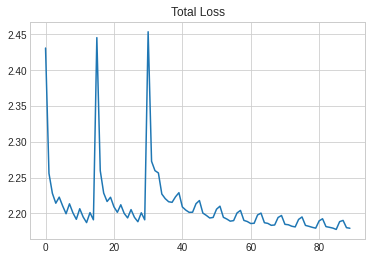

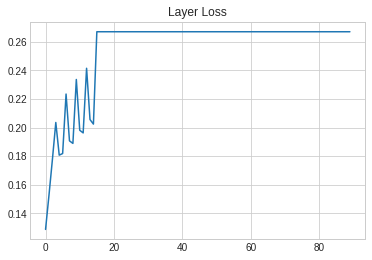

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
fig = plt.figure()
ax1 = plt.axes()
ax1.plot(loss_total);
plt.title("Total Loss")

fig = plt.figure()
ax2 = plt.axes()
ax2.plot(loss_total_layer);
plt.title("Layer Loss")

In [ ]:
print(mlp.weights[1].shape)
for i in range(len(mlp.weights)): print(mlp.weights[i].shape)

(256,)
(784, 256)
(256,)
(256,)
(256,)
(256, 10)
(10,)
(10,)
(10,)


# **Jacob Dataset**

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
X_ = np.load('./x_train.npy')
y_ = np.load('./y_train.npy')
X = np.zeros([133800,10])
y = np.zeros(133800)
X[0:133678, : ] = X_
y[0:133678] = y_
X[133678:133800,:] = X_[0:122,:]
y[133678:133800] = y_[0:122]
#X = X_[0:133600,:]
#y = y_[0:133600 ]
print(X_.shape)
print(y_.shape)
print(X.shape)
print(y.shape)

(133678, 10)
(133678,)
(133800, 10)
(133800,)


In [ ]:
#x_train = x_train.reshape(x_train.shape[0], -1) / 255
#x_test = x_test.reshape(x_test.shape[0], -1) / 255

batch_size = 200 # MUST HAVE ALL BATCHES of EQUAL SIZE (The last one may mess some )

one_hot_y_train = tf.one_hot(y.astype(np.float32), depth=2)
#one_hot_y_test = tf.one_hot(y_test.astype(np.float32), depth=10)

tr_dataset = tf.data.Dataset.from_tensor_slices((X, one_hot_y_train)).batch(batch_size)
#val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

In [ ]:
tr_dataset

<BatchDataset shapes: ((None, 10), (None, 2)), types: (tf.float64, tf.float32)>

In [ ]:
def x_Sigma_w_x_T(x, W_Sigma):
  batch_sz = x.shape[0]
  xx_t = tf.reduce_sum(tf.multiply(x, x),axis=1, keepdims=True)               # xxT is being calcualted
  xx_t_e = tf.expand_dims(xx_t,axis=2)                                      # Expand dimention of xxt
  return tf.multiply(xx_t_e, W_Sigma)

def w_t_Sigma_i_w (w_mu, in_Sigma):
  Sigma_1_1 = tf.matmul(tf.transpose(w_mu), in_Sigma)
  Sigma_1_2 = tf.matmul(Sigma_1_1, w_mu)
  return Sigma_1_2

def tr_Sigma_w_Sigma_in (in_Sigma, W_Sigma):
  Sigma_3_1 = tf.linalg.trace(in_Sigma)
  Sigma_3_2 = tf.expand_dims(Sigma_3_1, axis=1)
  Sigma_3_3 = tf.expand_dims(Sigma_3_2, axis=1)
  return tf.multiply(Sigma_3_3, W_Sigma) 

def activation_Sigma (gradi, Sigma_in):
  grad1 = tf.expand_dims(gradi,axis=2)
  grad2 = tf.expand_dims(gradi,axis=1)
  return tf.multiply(Sigma_in, tf.matmul(grad1, grad2))

In [ ]:
# Linear Class - First Layer (Constant * RV)
class LinearFirst(keras.layers.Layer):
    """y = w.x + b"""

    def __init__(self, units):
        super(LinearFirst, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w_mu = self.add_weight(name='w_mu',
            shape=(input_shape[-1], self.units),
            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.05, seed=None),
            trainable=True
        )
        self.w_sigma = self.add_weight(name='w_sigma',
            shape=(self.units,),
            initializer=tf.random_uniform_initializer(minval= -12., maxval=-2.2, seed=None),
            trainable=True
        )
        self.b_mu = self.add_weight(name='b_mu',
            shape=(self.units,), initializer=tf.random_normal_initializer( mean=0.0, stddev=0.00005, seed=None),
            trainable=True
        )
        self.b_sigma = self.add_weight(name='b_sigma',
            shape=(self.units,), initializer=tf.random_uniform_initializer(minval= -12., maxval=-10., seed=None),
            trainable=True
        )
    def call(self, inputs):
        # Mean
        #print(self.w_mu.shape)
        mu_out = tf.matmul(inputs, self.w_mu) + self.b_mu                         # Mean of the output
        # Varinace
        W_Sigma = tf.linalg.diag(tf.math.log(1. + tf.math.exp(self.w_sigma)))                                    # Construct W_Sigma from w_sigmas
        #W_Sigma = tf.linalg.diag(self.w_sigma)                                    # Construct W_Sigma from w_sigmas
        Sigma_out = x_Sigma_w_x_T(inputs, W_Sigma) + tf.math.log(1. + tf.math.exp(self.b_sigma)) #tf.linalg.diag(self.b_sigma)

        Term1 = tf.reduce_mean(tf.math.log(1.0 + Sigma_out))
        Term2 = tf.reduce_mean(tf.square(mu_out))
        Term3 = tf.reduce_mean(Sigma_out)
      
        kl_loss = -0.5 * (Term1 - Term2 - Term3)
        self.add_loss(kl_loss)

        return mu_out, Sigma_out

In [ ]:
# Linear Class - Second Layer (RV * RV)
class LinearNotFirst(keras.layers.Layer):
    """y = w.x + b"""

    def __init__(self, units):
        super(LinearNotFirst, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w_mu = self.add_weight(name='w_mu',
            shape=(input_shape[-1], self.units),
            initializer=tf.random_normal_initializer( mean=0.0, stddev=0.05, seed=None),
            trainable=True,
        )
        self.w_sigma = self.add_weight(name='w_sigma',
            shape=(self.units,),
            initializer=tf.random_uniform_initializer(minval= -12., maxval=-2.2, seed=None),
            trainable=True,
        )
        self.b_mu = self.add_weight(name='b_mu',
            shape=(self.units,), initializer=tf.random_normal_initializer( mean=0.0, stddev=0.00005, seed=None),
            trainable=True,
        )
        self.b_sigma = self.add_weight(name='b_sigma',
            shape=(self.units,), initializer=tf.random_uniform_initializer(minval= -12., maxval=-10., seed=None),
            trainable=True,
        )

    def call(self, mu_in, Sigma_in):
        #batch_sz = mu_in.shape[0]
        mu_out = tf.matmul(mu_in, self.w_mu) + self.b_mu
        W_Sigma = tf.linalg.diag(tf.math.log(1. + tf.math.exp(self.w_sigma)))  
        #W_Sigma = tf.linalg.diag(self.w_sigma)                                    # Construct W_Sigma from w_sigmas
        # Simga_out has three terms
        Sigma_1 = w_t_Sigma_i_w (self.w_mu, Sigma_in)
        Sigma_2 = x_Sigma_w_x_T(mu_in, W_Sigma)                                   #tf.keras.backend.print_tensor(inputs2[0,:,:])
        Sigma_3 = tr_Sigma_w_Sigma_in (Sigma_in, W_Sigma)
        Sigma_out = Sigma_1 + Sigma_2 + Sigma_3 +tf.linalg.diag(tf.math.log(1. + tf.math.exp(self.b_sigma)))  #+ tf.linalg.diag(self.b_sigma)
        
        Term1 = tf.reduce_mean(tf.math.log(1.0 + Sigma_out))
        Term2 = tf.reduce_mean(tf.square(mu_out))
        Term3 = tf.reduce_mean(Sigma_out)
        kl_loss = -0.5 * (Term1 - Term2 - Term3)
        self.add_loss(kl_loss)
        return mu_out, Sigma_out


In [ ]:
class myReLU(keras.layers.Layer):
    """ReLU"""

    def __init__(self):
        super(myReLU, self).__init__()
    def call(self, mu_in, Sigma_in):
        mu_out = tf.nn.relu(mu_in)
        with tf.GradientTape() as g:
          g.watch(mu_in)
          out = tf.nn.relu(mu_in)
        gradi = g.gradient(out, mu_in) 

        Sigma_out = activation_Sigma (gradi, Sigma_in)
        
        return mu_out, Sigma_out


In [ ]:
class mysoftmax(keras.layers.Layer):
    """Mysoftmax"""

    def __init__(self):
        super(mysoftmax, self).__init__()
    def call(self, mu_in, Sigma_in):
        mu_out = tf.nn.softmax(mu_in)
        pp1 = tf.expand_dims(mu_out, axis=2)
        pp2 = tf.expand_dims(mu_out, axis=1)
        ppT = tf.matmul(pp1, pp2)
        p_diag = tf.linalg.diag(mu_out)
        grad = p_diag - ppT
        Sigma_out = tf.matmul(grad, tf.matmul(Sigma_in, tf.transpose(grad, perm=[0, 2, 1])))
        return mu_out, Sigma_out

In [ ]:
# #############################
###### Cutom training loop
class exVDPMLP(tf.keras.Model):
    """Stack of Linear layers with a KL regularization loss."""

    def __init__(self, name=None):
        super(exVDPMLP, self).__init__()
        self.linear_1 = LinearFirst(256)
        self.myrelu_1 = myReLU()
        self.linear_2 = LinearNotFirst(2)
        self.mysoftma = mysoftmax()

    def call(self, inputs):
        m, s = self.linear_1 (inputs)
        m, s = self.myrelu_1 (m, s)
        m, s = self.linear_2 (m, s)
        outputs, Sigma = self.mysoftma(m, s)
        #print('Sample Sigma', Sigma[0,:,:])
        return outputs, Sigma

In [ ]:
def nll_gaussian(y_test, y_pred_mean, y_pred_sd, num_labels=2, batch_size=200):
    NS = tf.linalg.diag(tf.constant(1e-3, shape=[batch_size, num_labels]))
    I = tf.eye(num_labels, batch_shape=[batch_size])
    y_pred_sd_ns = y_pred_sd + NS
    y_pred_sd_inv = tf.linalg.solve(y_pred_sd_ns, I)
    mu_ = y_pred_mean - y_test
   # return tf.reduce_mean(mu_**2)
    mu_sigma = tf.matmul(mu_ ,  y_pred_sd_inv) 
    ms = 0.5*tf.matmul(mu_sigma , mu_, transpose_b=True) + 0.5*tf.linalg.slogdet(y_pred_sd_ns)[1]
    
    ms = tf.reduce_mean(ms)
    return(ms)

In [ ]:
# Cutom Trianing Loop with Graph
mlp = exVDPMLP(name='mlp')
#accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
#loss_fn = NLL_loss(num_labels=10, batch_size=100)
optimizer = tf.keras.optimizers.Adam()
loss_total=[]
@tf.function  # Make it fast.
def train_on_batch(x, y):
    with tf.GradientTape() as tape:
        logits, sigma = mlp(x)
        
       # loss_final = loss_fn( y, logits, sigma)
        loss_final = nll_gaussian(y, logits,   tf.clip_by_value(t=sigma, clip_value_min=tf.constant(-1e+10),
                                  clip_value_max=tf.constant(1e+10)))
        #loss_layers = sum(gru_model.losses)

        loss = loss_final #+ loss_layers

        gradients = tape.gradient(loss, mlp.trainable_weights)
    optimizer.apply_gradients(zip(gradients, mlp.trainable_weights))
    #acc = accuracy.update_state(y, logits)
    return loss, logits
epochs = 2
for epoch in range(epochs):
  print('Epoch: ', epoch, '/' , epochs)
  for step, (x, y) in enumerate(tr_dataset):
    loss, logits = train_on_batch(x, y)
   # logits1 = tf.math.argmax( logits, axis=1)
   # y1 = tf.math.argmax( y, axis=1)

    corr = tf.equal(tf.math.argmax(logits, 1),tf.math.argmax(y,1))   
    accuracy = tf.reduce_mean(tf.cast(corr,tf.float32))

  #  print(logits1)
   # print(y1)
   # accuracy.update_state(y1, logits1)
    if step % 1000 == 0:
        print("Step:", step, "Loss:", float(loss))
        print("Total running accuracy so far: %.3f" % accuracy)
        loss_total.append(loss)
  #for step, (x, y) in enumerate(val_dataset):
  #  logits, sigma = mlp(x)
  #  corr = tf.equal(tf.math.argmax(logits, 1),tf.math.argmax(y,1))   
  #  va_accuracy = tf.reduce_mean(tf.cast(corr,tf.float32))
  #  if step % 1 == 0:
  #    print("Total running accuracy so far: %.3f" % va_accuracy)
       # loss_total_layer.append(loss_layers)
  #accuracy.reset_states()

Epoch:  0 / 2

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Step: 0 Loss: 64.74752044677734
Total running accuracy so far: 0.240
Epoch:  1 / 2
Step: 0 Loss: -4.476774215698242
Total running accuracy so far: 0.985


In [ ]:
mlp.save_weights('./mlp')

In [ ]:
mlp.load_weights('./mlp')
test_no_steps = 0
logits_ = np.zeros([int(X.shape[0] / (batch_size)), batch_size, 2])
sigma_ = np.zeros([int(X.shape[0] / (batch_size)), batch_size, 2, 2])
for step, (x, y) in enumerate(tr_dataset):
  logits, sigma = mlp(x)  
  logits_[test_no_steps,:,:] =logits
  sigma_[test_no_steps, :, :, :]= sigma
  test_no_steps+=1

In [ ]:
sigma_[0,0,:,:]

array([[ 3.66357781e-05, -3.66358508e-05],
       [-3.66358508e-05,  3.66359309e-05]])

**MLP_Jacob_Data**

In [ ]:
import tensorflow as tf
from tensorflow import keras
import os
import imageio
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import math
import time, sys
import pickle
import timeit
#from Adding_noise import random_noise

plt.ioff()

# update_progress() : Displays or updates a console progress bar
## Accepts a float between 0 and 1. Any int will be converted to a float.
## A value under 0 represents a 'halt'.
## A value at 1 or bigger represents 100%
def update_progress(progress):
    barLength = 10 # Modify this to change the length of the progress bar
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rPercent: [{0}] {1}% {2}".format( "#"*block + "-"*(barLength-block), progress*100, status)
    sys.stdout.write(text)
    sys.stdout.flush()


def x_Sigma_w_x_T(x, W_Sigma):
  batch_sz = x.shape[0]
  xx_t = tf.reduce_sum(tf.multiply(x, x),axis=1, keepdims=True)               # xxT is being calcualted
  xx_t_e = tf.expand_dims(xx_t,axis=2)                                      # Expand dimention of xxt
  return tf.multiply(xx_t_e, W_Sigma)

def w_t_Sigma_i_w (w_mu, in_Sigma):
  Sigma_1_1 = tf.matmul(tf.transpose(w_mu), in_Sigma)
  Sigma_1_2 = tf.matmul(Sigma_1_1, w_mu)
  return Sigma_1_2

def tr_Sigma_w_Sigma_in (in_Sigma, W_Sigma):
  Sigma_3_1 = tf.linalg.trace(in_Sigma)
  Sigma_3_2 = tf.expand_dims(Sigma_3_1, axis=1)
  Sigma_3_3 = tf.expand_dims(Sigma_3_2, axis=1)
  return tf.multiply(Sigma_3_3, W_Sigma) 

def activation_Sigma (gradi, Sigma_in):
  grad1 = tf.expand_dims(gradi,axis=2)
  grad2 = tf.expand_dims(gradi,axis=1)
  return tf.multiply(Sigma_in, tf.matmul(grad1, grad2))
 



# Linear Class - First Layer (Constant * RV)
class LinearFirst(keras.layers.Layer):
    """y = w.x + b"""

    def __init__(self, units):
        super(LinearFirst, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w_mu = self.add_weight(name='w_mu',
            shape=(input_shape[-1], self.units),
            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.05, seed=None),
            trainable=True
        )
        self.w_sigma = self.add_weight(name='w_sigma',
            shape=(self.units,),
            initializer=tf.random_uniform_initializer(minval= -12., maxval=-2.2, seed=None),
            trainable=True
        )
        self.b_mu = self.add_weight(name='b_mu',
            shape=(self.units,), initializer=tf.random_normal_initializer( mean=0.0, stddev=0.00005, seed=None),
            trainable=True
        )
        self.b_sigma = self.add_weight(name='b_sigma',
            shape=(self.units,), initializer=tf.random_uniform_initializer(minval= -12., maxval=-10., seed=None),
            trainable=True
        )
    def call(self, inputs):
        # Mean
        #print(self.w_mu.shape)
        mu_out = tf.matmul(inputs, self.w_mu) + self.b_mu                         # Mean of the output
        # Varinace
        W_Sigma = tf.linalg.diag(tf.math.log(1. + tf.math.exp(self.w_sigma)))                                    # Construct W_Sigma from w_sigmas
        #W_Sigma = tf.linalg.diag(self.w_sigma)                                    # Construct W_Sigma from w_sigmas
        Sigma_out = x_Sigma_w_x_T(inputs, W_Sigma) + tf.math.log(1. + tf.math.exp(self.b_sigma)) #tf.linalg.diag(self.b_sigma)

        Term1 = tf.reduce_mean(tf.math.log(1.0 + Sigma_out))
        Term2 = tf.reduce_mean(tf.square(mu_out))
        Term3 = tf.reduce_mean(Sigma_out)
      
        kl_loss = -0.5 * (Term1 - Term2 - Term3)
        self.add_loss(kl_loss)

        return mu_out, Sigma_out


# Linear Class - Second Layer (RV * RV)
class LinearNotFirst(keras.layers.Layer):
    """y = w.x + b"""

    def __init__(self, units):
        super(LinearNotFirst, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w_mu = self.add_weight(name='w_mu',
            shape=(input_shape[-1], self.units),
            initializer=tf.random_normal_initializer( mean=0.0, stddev=0.05, seed=None),
            trainable=True,
        )
        self.w_sigma = self.add_weight(name='w_sigma',
            shape=(self.units,),
            initializer=tf.random_uniform_initializer(minval= -12., maxval=-2.2, seed=None),
            trainable=True,
        )
        self.b_mu = self.add_weight(name='b_mu',
            shape=(self.units,), initializer=tf.random_normal_initializer( mean=0.0, stddev=0.00005, seed=None),
            trainable=True,
        )
        self.b_sigma = self.add_weight(name='b_sigma',
            shape=(self.units,), initializer=tf.random_uniform_initializer(minval= -12., maxval=-10., seed=None),
            trainable=True,
        )

    def call(self, mu_in, Sigma_in):
        #batch_sz = mu_in.shape[0]
        mu_out = tf.matmul(mu_in, self.w_mu) + self.b_mu
        
      #  W_Sigma = tf.linalg.diag(self.w_sigma)  
        W_Sigma = tf.linalg.diag(tf.math.log(1. + tf.math.exp(self.w_sigma)))                                   # Construct W_Sigma from w_sigmas
        # Simga_out has three terms
        Sigma_1 = w_t_Sigma_i_w (self.w_mu, Sigma_in)
        Sigma_2 = x_Sigma_w_x_T(mu_in, W_Sigma)                                   
        Sigma_3 = tr_Sigma_w_Sigma_in (Sigma_in, W_Sigma)
        Sigma_out = Sigma_1 + Sigma_2 + Sigma_3 + tf.linalg.diag(tf.math.log(1. + tf.math.exp(self.b_sigma))) #+ tf.linalg.diag(self.b_sigma)
        
        Term1 = tf.reduce_mean(tf.math.log(1.0 + Sigma_out))
        Term2 = tf.reduce_mean(tf.square(mu_out))
        Term3 = tf.reduce_mean(Sigma_out)
        kl_loss = -0.5 * (Term1 - Term2 - Term3)
        self.add_loss(kl_loss)
        return mu_out, Sigma_out

class myReLU(keras.layers.Layer):
    """ReLU"""

    def __init__(self):
        super(myReLU, self).__init__()
    def call(self, mu_in, Sigma_in):
        mu_out = tf.nn.relu(mu_in)
        with tf.GradientTape() as g:
          g.watch(mu_in)
          out = tf.nn.relu(mu_in)
        gradi = g.gradient(out, mu_in) 

        Sigma_out = activation_Sigma (gradi, Sigma_in)
        
        return mu_out, Sigma_out

class mysoftmax(keras.layers.Layer):
    """Mysoftmax"""

    def __init__(self):
        super(mysoftmax, self).__init__()
    def call(self, mu_in, Sigma_in):
        mu_out = tf.nn.softmax(mu_in)
        pp1 = tf.expand_dims(mu_out, axis=2)
        pp2 = tf.expand_dims(mu_out, axis=1)
        ppT = tf.matmul(pp1, pp2)
        p_diag = tf.linalg.diag(mu_out)
        grad = p_diag - ppT
        Sigma_out = tf.matmul(grad, tf.matmul(Sigma_in, tf.transpose(grad, perm=[0, 2, 1])))
        return mu_out, Sigma_out


def nll_gaussian(y_test, y_pred_mean, y_pred_sd, num_labels=2, batch_size=200):
    NS = tf.linalg.diag(tf.constant(1e-3, shape=[batch_size, num_labels]))
    I = tf.eye(num_labels, batch_shape=[batch_size])
    y_pred_sd_ns = y_pred_sd + NS
    y_pred_sd_inv = tf.linalg.solve(y_pred_sd_ns, I)
    mu_ = y_pred_mean - y_test
    mu_sigma = tf.matmul(mu_ ,  y_pred_sd_inv) 
    ms = 0.5*tf.matmul(mu_sigma , mu_, transpose_b=True) + 0.5*tf.linalg.slogdet(y_pred_sd_ns)[1]
    ms = tf.reduce_mean(ms)
    return(ms)

class exVDPMLP(tf.keras.Model):
    """Stack of Linear layers with a KL regularization loss."""

    def __init__(self, name=None):
        super(exVDPMLP, self).__init__()
        self.linear_1 = LinearFirst(256)
        self.myrelu_1 = myReLU()
        self.linear_2 = LinearNotFirst(2)
        self.mysoftma = mysoftmax()

    def call(self, inputs):
        m, s = self.linear_1 (inputs)
        m, s = self.myrelu_1 (m, s)
        m, s = self.linear_2 (m, s)
        outputs, Sigma = self.mysoftma(m, s)
        #print('Sample Sigma', Sigma[0,:,:])
        return outputs, Sigma

def main_function( input_dim = 10, units = 256, output_size = 2 , batch_size = 200, epochs = 5, lr = 0.001, 
         Random_noise=True, gaussain_noise_std=10000, Training = False):
    

    PATH = './saved_models/DP_MLP_epoch_{}/'.format(epochs)
    X = np.load('./x_train.npy')
    y = np.load('./y_train.npy')
    x_train = X[0:120000,:]
    y_train = y[0:120000]
    x_test = X[120000:133600,:]
    y_test = y[120000:133600]   

    one_hot_y_train = tf.one_hot(y_train.astype(np.float32), depth=2)
    one_hot_y_test = tf.one_hot(y_test.astype(np.float32), depth=2) 

    tr_dataset = tf.data.Dataset.from_tensor_slices((x_train, one_hot_y_train)).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices((x_test, one_hot_y_test)).batch(batch_size)

        
    # Cutom Trianing Loop with Graph
    mlp_model = exVDPMLP(name='mlp')    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    @tf.function  # Make it fast.
    def train_on_batch(x, y):
        with tf.GradientTape() as tape:
            logits, sigma = mlp_model(x)      
            loss_final = nll_gaussian(y, logits,  tf.clip_by_value(t=sigma, clip_value_min=tf.constant(-1e+10),
                                       clip_value_max=tf.constant(1e+10)), output_size , batch_size)
            #loss_layers = sum(mlp_model.losses)

            loss = loss_final #+ loss_layers
            gradients = tape.gradient(loss, mlp_model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, mlp_model.trainable_weights))        
        return loss, logits
    if Training:
        train_acc = np.zeros(epochs) 
        valid_acc = np.zeros(epochs)
        train_err = np.zeros(epochs)
        valid_error = np.zeros(epochs)
        start = timeit.default_timer()
        
        for epoch in range(epochs):
          print('Epoch: ', epoch+1, '/' , epochs)
    
          acc1 = 0 
          acc_valid1 = 0 
          err1 = 0
          err_valid1 = 0
          tr_no_steps = 0          
          #Training
          for step, (x, y) in enumerate(tr_dataset):
              update_progress(step / int(x_train.shape[0] / (batch_size)) )  
              loss, logits = train_on_batch(x, y)
              err1+= loss
    
              corr = tf.equal(tf.math.argmax(logits, axis=1),tf.math.argmax(y,axis=1))
              accuracy = tf.reduce_mean(tf.cast(corr,tf.float32))
              acc1+=accuracy
            #  if step % 2000 == 0:
            #      print("Step:", step, "Loss:", float(loss))
            #      print("Total running accuracy so far: %.3f" % accuracy)             
                  
              tr_no_steps+=1
          train_acc[epoch] = acc1/tr_no_steps
          train_err[epoch] = err1/tr_no_steps
          
          print('Training Acc  ', train_acc[epoch])
          print('Training error  ', train_err[epoch])          
          
        stop = timeit.default_timer()
        print('Total Training Time: ', stop - start)
        print('Training Acc  ', np.mean(train_acc))          
        print('Training error  ', np.mean(train_err))       
    
        
        mlp_model.save_weights(PATH + 'DP_MLP_model')
        
        if (epochs > 1):
            fig = plt.figure(figsize=(15,7))
            plt.plot(train_acc, 'b', label='Training acc')            
            plt.ylim(0, 1.1)
            plt.title("Density Propagation MLP on MNIST Data")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.legend(loc='lower right')
            plt.savefig(PATH + 'DP_MLP_on_MNIST_Data_acc.png')
            plt.close(fig)
    
    
            fig = plt.figure(figsize=(15,7))
            plt.plot(train_err, 'b', label='Training error')            
            plt.title("Density Propagation MLP on MNIST Data")
            plt.xlabel("Epochs")
            plt.ylabel("Error")
            plt.legend(loc='lower right')
            plt.savefig(PATH + 'DP_MLP_on_MNIST_Data_error.png')
            plt.close(fig)
        f = open(PATH + 'training_validation_acc_error.pkl', 'wb')         
        pickle.dump([train_acc, train_err], f)                                                   
        f.close()         
             
             
        textfile = open(PATH + 'Related_hyperparameters.txt','w')    
        textfile.write(' Input Dimension : ' +str(input_dim))
        textfile.write('\n No Hidden Nodes : ' +str(units))
        textfile.write('\n Output Size : ' +str(output_size))
        textfile.write('\n No of epochs : ' +str(epochs))
        textfile.write('\n Learning rate : ' +str(lr))            
        textfile.write("\n---------------------------------")
        if Training: 
            textfile.write('\n Total run time in sec : ' +str(stop - start))
            if(epochs == 1):
                textfile.write("\n Averaged Training  Accuracy : "+ str( train_acc))                  
                textfile.write("\n Averaged Training  error : "+ str( train_err))               
            else:
                textfile.write("\n Averaged Training  Accuracy : "+ str(np.mean(train_acc)))               
                textfile.write("\n Averaged Training  error : "+ str(np.mean(train_err)))               
        textfile.write("\n---------------------------------")                
        textfile.write("\n---------------------------------")    
        textfile.close()
        
    else:
        test_path = 'test_results_random_noise_{}/'.format(gaussain_noise_std)
        mlp_model.load_weights(PATH + 'DP_MLP_model')
        test_no_steps = 0
        err_test = 0
        acc_test = 0
        true_x = np.zeros([int(x_test.shape[0] / (batch_size)), batch_size,  input_dim])
        true_y = np.zeros([int(x_test.shape[0] / (batch_size)), batch_size, output_size])
        logits_ = np.zeros([int(x_test.shape[0] / (batch_size)), batch_size, output_size])
        sigma_ = np.zeros([int(x_test.shape[0] / (batch_size)), batch_size, output_size, output_size])
        for step, (x, y) in enumerate(val_dataset):
          update_progress(step / int(x_test.shape[0] / (batch_size)) ) 
          true_x[test_no_steps, :, :] = x
          true_y[test_no_steps, :, :] = y
          if Random_noise:
              noise = tf.random.normal(shape = [batch_size, input_dim], mean = 0.0, stddev = gaussain_noise_std, dtype = x.dtype ) 
              x = x +  noise 
        
          logits, sigma = mlp_model(x)  
          logits_[test_no_steps,:,:] =logits
          sigma_[test_no_steps, :, :, :]= sigma
          tloss = nll_gaussian(y, logits,  tf.clip_by_value(t=sigma, clip_value_min=tf.constant(-1e+10), clip_value_max=tf.constant(1e+10)), output_size , batch_size)
          err_test+= tloss
          
          corr = tf.equal(tf.math.argmax(logits, axis=1),tf.math.argmax(y,axis=1))
          accuracy = tf.reduce_mean(tf.cast(corr,tf.float32))
          acc_test+=accuracy

          if step % 500 == 0:
              print("Step:", step, "Loss:", float(tloss))
              print("Total running accuracy so far: %.3f" % accuracy)              
           # loss_total_layer.append(loss_layers)
          test_no_steps+=1
       
        test_acc = acc_test/test_no_steps      
        test_error = err_test/test_no_steps
        print('Test accuracy : ', test_acc.numpy())
        print('Test error : ', test_error.numpy())
        
        pf = open(PATH + test_path + 'uncertainty_info.pkl', 'wb')         
        pickle.dump([logits_, sigma_, true_x, true_y, test_acc.numpy(), test_error.numpy()  ], pf)                                                   
        pf.close()
        
        textfile = open(PATH + test_path + 'Related_hyperparameters.txt','w')    
        textfile.write(' Input Dimension : ' +str(input_dim))
        textfile.write('\n No Hidden Nodes : ' +str(units))
        textfile.write('\n Output Size : ' +str(output_size))
        textfile.write('\n No of epochs : ' +str(epochs))
        textfile.write('\n Learning rate : ' +str(lr))          
        textfile.write("\n---------------------------------")
        textfile.write("\n Averaged Test Accuracy : "+ str( test_acc.numpy()))
        textfile.write("\n Averaged Test error : "+ str(test_error.numpy() ))            
        textfile.write("\n---------------------------------")
        if Random_noise:
            textfile.write('\n Random Noise std: '+ str(gaussain_noise_std ))              
        textfile.write("\n---------------------------------")    
        textfile.close()
            
if __name__ == '__main__':
    main_function()    


Percent: [----------] 0.0% WARNING:tensorflow:Layer ex_vdpmlp_33 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Step: 0 Loss: -3.3077564239501953
Total running accuracy so far: 0.920
Percent: [##########] 98.52941176470588% Test accuracy :  0.92058825
Test error :  -2.5596993


In [ ]:
#@title save yo data to drive
filename = "saved_models" #@param {type:"string"}
folders_or_files_to_save = "saved_models" #@param {type:"string"}
from google.colab import files
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

def save_file_to_drive(name, path):
    file_metadata = {
    'name': name,
    'mimeType': 'application/octet-stream'
    }

    media = MediaFileUpload(path, 
                  mimetype='application/octet-stream',
                  resumable=True)

    created = drive_service.files().create(body=file_metadata, media_body=media, fields='id').execute()

    print('File ID: {}'.format(created.get('id')))

    return created


extension_zip = ".zip"

zip_file = filename + extension_zip

# !rm -rf $zip_file
!zip -r $zip_file {folders_or_files_to_save} # FOLDERS TO SAVE INTO ZIP FILE

auth.authenticate_user()
drive_service = build('drive', 'v3')

destination_name = zip_file
path_to_file = zip_file
save_file_to_drive(destination_name, path_to_file)

updating: saved_models/ (stored 0%)
updating: saved_models/DP_MLP_epoch_1/ (stored 0%)
updating: saved_models/DP_MLP_epoch_1/DP_MLP_model.data-00000-of-00002 (deflated 73%)
updating: saved_models/DP_MLP_epoch_1/training_validation_acc_error.pkl (deflated 15%)
updating: saved_models/DP_MLP_epoch_1/DP_MLP_model.data-00001-of-00002 (deflated 6%)
updating: saved_models/DP_MLP_epoch_1/checkpoint (deflated 41%)
updating: saved_models/DP_MLP_epoch_1/DP_MLP_model.index (deflated 54%)
updating: saved_models/DP_MLP_epoch_1/Related_hyperparameters.txt (deflated 45%)
updating: saved_models/.ipynb_checkpoints/ (stored 0%)
updating: saved_models/DP_MLP_epoch_20/ (stored 0%)
updating: saved_models/DP_MLP_epoch_20/DP_MLP_model.data-00000-of-00002 (deflated 73%)
updating: saved_models/DP_MLP_epoch_20/training_validation_acc_error.pkl (deflated 45%)
updating: saved_models/DP_MLP_epoch_20/DP_MLP_on_MNIST_Data_acc.png (deflated 26%)
updating: saved_models/DP_MLP_epoch_20/test_results_random_noise_0.4/ (st

{'id': '1aBPFxw4MmUHn3c6PZClfgyVvPYk8uv5b'}

In [ ]:
import tensorflow as tf
from tensorflow import keras
import os
import imageio
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import math
import time, sys
import pickle
import timeit
#from Adding_noise import random_noise

plt.ioff()

# update_progress() : Displays or updates a console progress bar
## Accepts a float between 0 and 1. Any int will be converted to a float.
## A value under 0 represents a 'halt'.
## A value at 1 or bigger represents 100%
def update_progress(progress):
    barLength = 10 # Modify this to change the length of the progress bar
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rPercent: [{0}] {1}% {2}".format( "#"*block + "-"*(barLength-block), progress*100, status)
    sys.stdout.write(text)
    sys.stdout.flush()


def x_Sigma_w_x_T(x, W_Sigma):
  batch_sz = x.shape[0]
  xx_t = tf.reduce_sum(tf.multiply(x, x),axis=1, keepdims=True)               
  xx_t_e = tf.expand_dims(xx_t,axis=2)                                     
  return tf.multiply(xx_t_e, W_Sigma)

def w_t_Sigma_i_w (w_mu, in_Sigma):
  Sigma_1_1 = tf.matmul(tf.transpose(w_mu), in_Sigma)
  Sigma_1_2 = tf.matmul(Sigma_1_1, w_mu)
  return Sigma_1_2

def tr_Sigma_w_Sigma_in (in_Sigma, W_Sigma):
  Sigma_3_1 = tf.linalg.trace(in_Sigma)
  Sigma_3_2 = tf.expand_dims(Sigma_3_1, axis=1)
  Sigma_3_3 = tf.expand_dims(Sigma_3_2, axis=1)
  return tf.multiply(Sigma_3_3, W_Sigma) 

def activation_Sigma (gradi, Sigma_in):
  grad1 = tf.expand_dims(gradi,axis=2)
  grad2 = tf.expand_dims(gradi,axis=1)
  return tf.multiply(Sigma_in, tf.matmul(grad1, grad2))
 



# Linear Class - First Layer (Constant * RV)
class LinearFirst(keras.layers.Layer):
    """y = w.x + b"""

    def __init__(self, units):
        super(LinearFirst, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w_mu = self.add_weight(name='w_mu',
            shape=(input_shape[-1], self.units),
            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.05, seed=None),
            trainable=True
        )
        self.w_sigma = self.add_weight(name='w_sigma',
            shape=(self.units,),
            initializer=tf.random_uniform_initializer(minval= -12., maxval=-2.2, seed=None),
            trainable=True
        )
        self.b_mu = self.add_weight(name='b_mu',
            shape=(self.units,), initializer=tf.random_normal_initializer( mean=0.0, stddev=0.00005, seed=None),
            trainable=True
        )
        self.b_sigma = self.add_weight(name='b_sigma',
            shape=(self.units,), initializer=tf.random_uniform_initializer(minval= -12., maxval=-10., seed=None),
            trainable=True
        )
    def call(self, inputs):
        # Mean
        #print(self.w_mu.shape)
        mu_out = tf.matmul(inputs, self.w_mu) + self.b_mu                         # Mean of the output
        # Varinace
        W_Sigma = tf.linalg.diag(tf.math.log(1. + tf.math.exp(self.w_sigma)))                                        
        Sigma_out = x_Sigma_w_x_T(inputs, W_Sigma) + tf.math.log(1. + tf.math.exp(self.b_sigma)) 

        Term1 = self.w_mu.shape[0]*tf.math.log(tf.math.log(1. + tf.math.exp(self.w_sigma)))
        Term2 = tf.reduce_sum(tf.reduce_sum(tf.abs(self.w_mu)))
        Term3 = self.w_mu.shape[0]*tf.math.log(1. + tf.math.exp(self.w_sigma))      
      
        kl_loss = -0.5 * tf.reduce_mean(Term1 - Term2 - Term3)
        self.add_loss(kl_loss)

        return mu_out, Sigma_out


# Linear Class - Second Layer (RV * RV)
class LinearNotFirst(keras.layers.Layer):
    """y = w.x + b"""

    def __init__(self, units):
        super(LinearNotFirst, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w_mu = self.add_weight(name='w_mu',
            shape=(input_shape[-1], self.units),
            initializer=tf.random_normal_initializer( mean=0.0, stddev=0.05, seed=None),
            trainable=True,
        )
        self.w_sigma = self.add_weight(name='w_sigma',
            shape=(self.units,),
            initializer=tf.random_uniform_initializer(minval= -12., maxval=-2.2, seed=None),
            trainable=True,
        )
        self.b_mu = self.add_weight(name='b_mu',
            shape=(self.units,), initializer=tf.random_normal_initializer( mean=0.0, stddev=0.00005, seed=None),
            trainable=True,
        )
        self.b_sigma = self.add_weight(name='b_sigma',
            shape=(self.units,), initializer=tf.random_uniform_initializer(minval= -12., maxval=-10., seed=None),
            trainable=True,
        )

    def call(self, mu_in, Sigma_in):
        
        mu_out = tf.matmul(mu_in, self.w_mu) + self.b_mu    
        W_Sigma = tf.linalg.diag(tf.math.log(1. + tf.math.exp(self.w_sigma)))                                   
        # Simga_out has three terms
        Sigma_1 = w_t_Sigma_i_w (self.w_mu, Sigma_in)
        Sigma_2 = x_Sigma_w_x_T(mu_in, W_Sigma)                                   
        Sigma_3 = tr_Sigma_w_Sigma_in (Sigma_in, W_Sigma)
        Sigma_out = Sigma_1 + Sigma_2 + Sigma_3 + tf.linalg.diag(tf.math.log(1. + tf.math.exp(self.b_sigma))) 
        
        Term1 = self.w_mu.shape[0]*tf.math.log(tf.math.log(1. + tf.math.exp(self.w_sigma)))
        Term2 = tf.math.reduce_sum(tf.reduce_sum(tf.abs(self.w_mu)))
        Term3 = self.w_mu.shape[0]*tf.math.log(1. + tf.math.exp(self.w_sigma))    
        kl_loss = -0.5 * tf.reduce_mean(Term1 - Term2 - Term3)
        self.add_loss(kl_loss)
        return mu_out, Sigma_out

class myReLU(keras.layers.Layer):
    """ReLU"""

    def __init__(self):
        super(myReLU, self).__init__()
    def call(self, mu_in, Sigma_in):
        mu_out = tf.nn.relu(mu_in)
        with tf.GradientTape() as g:
          g.watch(mu_in)
          out = tf.nn.relu(mu_in)
        gradi = g.gradient(out, mu_in) 

        Sigma_out = activation_Sigma (gradi, Sigma_in)
        
        return mu_out, Sigma_out

class mysoftmax(keras.layers.Layer):
    """Mysoftmax"""

    def __init__(self):
        super(mysoftmax, self).__init__()
    def call(self, mu_in, Sigma_in):
        mu_out = tf.nn.softmax(mu_in)
        pp1 = tf.expand_dims(mu_out, axis=2)
        pp2 = tf.expand_dims(mu_out, axis=1)
        ppT = tf.matmul(pp1, pp2)
        p_diag = tf.linalg.diag(mu_out)
        grad = p_diag - ppT
        Sigma_out = tf.matmul(grad, tf.matmul(Sigma_in, tf.transpose(grad, perm=[0, 2, 1])))
        return mu_out, Sigma_out


def nll_gaussian(y_test, y_pred_mean, y_pred_sd, num_labels=2, batch_size=200):
    NS = tf.linalg.diag(tf.constant(1e-3, shape=[batch_size, num_labels]))
    I = tf.eye(num_labels, batch_shape=[batch_size])
    y_pred_sd_ns = y_pred_sd + NS
    y_pred_sd_inv = tf.linalg.solve(y_pred_sd_ns, I)
    mu_ = y_pred_mean - y_test
    mu_sigma = tf.matmul(mu_ ,  y_pred_sd_inv) 
    ms = 0.5*tf.matmul(mu_sigma , mu_, transpose_b=True) + 0.5*tf.linalg.slogdet(y_pred_sd_ns)[1]
    ms = tf.reduce_mean(ms)
    return(ms)

class exVDPMLP(tf.keras.Model):
    """Stack of Linear layers with a KL regularization loss."""

    def __init__(self, name=None):
        super(exVDPMLP, self).__init__()
        self.linear_1 = LinearFirst(256)
        self.myrelu_1 = myReLU()
        self.linear_2 = LinearNotFirst(2)
        self.mysoftma = mysoftmax()

    def call(self, inputs):
        m, s = self.linear_1 (inputs)
        m, s = self.myrelu_1 (m, s)
        m, s = self.linear_2 (m, s)
        outputs, Sigma = self.mysoftma(m, s)        
        return outputs, Sigma

def main_function( input_dim = 10, units = 256, output_size = 2 , batch_size = 200, epochs = 20, lr = 0.001, 
         Random_noise=True, gaussain_noise_std=1, Training = False):
    

    PATH = './saved_models/DP_MLP_epoch_{}/'.format(epochs)
    X = np.load('./x_train.npy')
    y = np.load('./y_train.npy')
    x_train = X[0:120000,:]
    y_train = y[0:120000]
    x_test = X[120000:133600,:]
    y_test = y[120000:133600]   

    one_hot_y_train = tf.one_hot(y_train.astype(np.float32), depth=2)
    one_hot_y_test = tf.one_hot(y_test.astype(np.float32), depth=2) 

    tr_dataset = tf.data.Dataset.from_tensor_slices((x_train, one_hot_y_train)).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices((x_test, one_hot_y_test)).batch(batch_size)

        
    # Cutom Trianing Loop with Graph
    mlp_model = exVDPMLP(name='mlp')    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    @tf.function  # Make it fast.
    def train_on_batch(x, y):
        with tf.GradientTape() as tape:
            logits, sigma = mlp_model(x)      
            loss_final = nll_gaussian(y, logits,  tf.clip_by_value(t=sigma, clip_value_min=tf.constant(-1e+10),
                                       clip_value_max=tf.constant(1e+10)), output_size , batch_size)
            loss_layers = sum(mlp_model.losses)

            loss = loss_final + 0.001*loss_layers
            gradients = tape.gradient(loss, mlp_model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, mlp_model.trainable_weights))        
        return loss, logits
    if Training:
        train_acc = np.zeros(epochs) 
        valid_acc = np.zeros(epochs)
        train_err = np.zeros(epochs)
        valid_error = np.zeros(epochs)
        start = timeit.default_timer()
        
        for epoch in range(epochs):
          print('Epoch: ', epoch+1, '/' , epochs)
    
          acc1 = 0 
          acc_valid1 = 0 
          err1 = 0
          err_valid1 = 0
          tr_no_steps = 0          
          #Training
          for step, (x, y) in enumerate(tr_dataset):
              update_progress(step / int(x_train.shape[0] / (batch_size)) )  
              loss, logits = train_on_batch(x, y)
              err1+= loss
    
              corr = tf.equal(tf.math.argmax(logits, axis=1),tf.math.argmax(y,axis=1))
              accuracy = tf.reduce_mean(tf.cast(corr,tf.float32))
              acc1+=accuracy                 
              tr_no_steps+=1
          train_acc[epoch] = acc1/tr_no_steps
          train_err[epoch] = err1/tr_no_steps
          
          print('Training Acc  ', train_acc[epoch])
          print('Training error  ', train_err[epoch])          
          
        stop = timeit.default_timer()
        print('Total Training Time: ', stop - start)
        print('Training Acc  ', np.mean(train_acc))          
        print('Training error  ', np.mean(train_err))       
    
        
        mlp_model.save_weights(PATH + 'DP_MLP_model')
        
        if (epochs > 1):
            fig = plt.figure(figsize=(15,7))
            plt.plot(train_acc, 'b', label='Training acc')            
            plt.ylim(0, 1.1)
            plt.title("Density Propagation MLP on MNIST Data")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.legend(loc='lower right')
            plt.savefig(PATH + 'DP_MLP_on_MNIST_Data_acc.png')
            plt.close(fig)
    
    
            fig = plt.figure(figsize=(15,7))
            plt.plot(train_err, 'b', label='Training error')            
            plt.title("Density Propagation MLP on MNIST Data")
            plt.xlabel("Epochs")
            plt.ylabel("Error")
            plt.legend(loc='lower right')
            plt.savefig(PATH + 'DP_MLP_on_MNIST_Data_error.png')
            plt.close(fig)
        f = open(PATH + 'training_validation_acc_error.pkl', 'wb')         
        pickle.dump([train_acc, train_err], f)                                                   
        f.close()         
             
             
        textfile = open(PATH + 'Related_hyperparameters.txt','w')    
        textfile.write(' Input Dimension : ' +str(input_dim))
        textfile.write('\n No Hidden Nodes : ' +str(units))
        textfile.write('\n Output Size : ' +str(output_size))
        textfile.write('\n No of epochs : ' +str(epochs))
        textfile.write('\n Learning rate : ' +str(lr))            
        textfile.write("\n---------------------------------")
        if Training: 
            textfile.write('\n Total run time in sec : ' +str(stop - start))
            if(epochs == 1):
                textfile.write("\n Averaged Training  Accuracy : "+ str( train_acc))                  
                textfile.write("\n Averaged Training  error : "+ str( train_err))               
            else:
                textfile.write("\n Averaged Training  Accuracy : "+ str(np.mean(train_acc)))               
                textfile.write("\n Averaged Training  error : "+ str(np.mean(train_err)))               
        textfile.write("\n---------------------------------")                
        textfile.write("\n---------------------------------")    
        textfile.close()
        
    else:
        test_path = 'test_results_random_noise_{}/'.format(gaussain_noise_std)
        mlp_model.load_weights(PATH + 'DP_MLP_model')
        test_no_steps = 0
        err_test = 0
        acc_test = 0
        true_x = np.zeros([int(x_test.shape[0] / (batch_size)), batch_size,  input_dim])
        true_y = np.zeros([int(x_test.shape[0] / (batch_size)), batch_size, output_size])
        logits_ = np.zeros([int(x_test.shape[0] / (batch_size)), batch_size, output_size])
        sigma_ = np.zeros([int(x_test.shape[0] / (batch_size)), batch_size, output_size, output_size])
        for step, (x, y) in enumerate(val_dataset):
          update_progress(step / int(x_test.shape[0] / (batch_size)) ) 
          true_x[test_no_steps, :, :] = x
          true_y[test_no_steps, :, :] = y
          if Random_noise:
              noise = tf.random.normal(shape = [batch_size, input_dim], mean = 0.0, stddev = gaussain_noise_std, dtype = x.dtype ) 
              x = x +  noise 

          loss_layers = sum(mlp_model.losses)       
          logits, sigma = mlp_model(x)  
          logits_[test_no_steps,:,:] =logits
          sigma_[test_no_steps, :, :, :]= sigma
          tloss = nll_gaussian(y, logits,  tf.clip_by_value(t=sigma, clip_value_min=tf.constant(-1e+10), clip_value_max=tf.constant(1e+10)), output_size , batch_size)+ 0.001*loss_layers
          err_test+= tloss
          
          corr = tf.equal(tf.math.argmax(logits, axis=1),tf.math.argmax(y,axis=1))
          accuracy = tf.reduce_mean(tf.cast(corr,tf.float32))
          acc_test+=accuracy

          if step % 500 == 0:
              print("Step:", step, "Loss:", float(tloss))
              print("Total running accuracy so far: %.3f" % accuracy)              
           
          test_no_steps+=1
       
        test_acc = acc_test/test_no_steps      
        test_error = err_test/test_no_steps
        print('Test accuracy : ', test_acc.numpy())
        print('Test error : ', test_error.numpy())
        
        pf = open(PATH + test_path + 'uncertainty_info.pkl', 'wb')         
        pickle.dump([logits_, sigma_, true_x, true_y, test_acc.numpy(), test_error.numpy()  ], pf)                                                   
        pf.close()
        
        textfile = open(PATH + test_path + 'Related_hyperparameters.txt','w')    
        textfile.write(' Input Dimension : ' +str(input_dim))
        textfile.write('\n No Hidden Nodes : ' +str(units))
        textfile.write('\n Output Size : ' +str(output_size))
        textfile.write('\n No of epochs : ' +str(epochs))
        textfile.write('\n Learning rate : ' +str(lr))          
        textfile.write("\n---------------------------------")
        textfile.write("\n Averaged Test Accuracy : "+ str( test_acc.numpy()))
        textfile.write("\n Averaged Test error : "+ str(test_error.numpy() ))            
        textfile.write("\n---------------------------------")
        if Random_noise:
            textfile.write('\n Random Noise std: '+ str(gaussain_noise_std ))              
        textfile.write("\n---------------------------------")    
        textfile.close()
            
if __name__ == '__main__':
    main_function()    


Percent: [----------] 0.0% WARNING:tensorflow:Layer ex_vdpmlp_15 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Step: 0 Loss: -3.540673017501831
Total running accuracy so far: 0.930
Percent: [##########] 98.52941176470588% Test accuracy :  0.92830884
Test error :  -4.916086
